In [9]:
import matplotlib.pyplot as plt
import numpy as np
import re

## Organized climate data

In [10]:
#cities in data.csv
CITIES = [
    'BOSTON',
    'SEATTLE',
    'SAN DIEGO',
    'PHILADELPHIA',
    'PHOENIX',
    'LAS VEGAS',
    'CHARLOTTE',
    'DALLAS',
    'BALTIMORE',
    'SAN JUAN',
    'LOS ANGELES',
    'MIAMI',
    'NEW ORLEANS',
    'ALBUQUERQUE',
    'PORTLAND',
    'SAN FRANCISCO',
    'TAMPA',
    'NEW YORK',
    'DETROIT',
    'ST LOUIS',
    'CHICAGO']

TRAINING_INTERVAL = range(1961, 2010)
TESTING_INTERVAL = range(2010, 2016)

In [11]:
class Climate(object):

    def __init__(self, filename):
        self.rawdata = {}

        f = open(filename, 'r')
        header = f.readline().strip().split(',')
        for line in f:
            items = line.strip().split(',')

            date = re.match('(\d\d\d\d)(\d\d)(\d\d)', items[header.index('DATE')])
            year = int(date.group(1))
            month = int(date.group(2))
            day = int(date.group(3))

            city = items[header.index('CITY')]
            temperature = float(items[header.index('TEMP')])
            if city not in self.rawdata:
                self.rawdata[city] = {}
            if year not in self.rawdata[city]:
                self.rawdata[city][year] = {}
            if month not in self.rawdata[city][year]:
                self.rawdata[city][year][month] = {}
            self.rawdata[city][year][month][day] = temperature
            
        f.close()

    def get_yearly_temp(self, city, year):
        temperatures = []
        assert city in self.rawdata, "provided city is not available"
        assert year in self.rawdata[city], "provided year is not available"
        for month in range(1, 13):
            for day in range(1, 32):
                if day in self.rawdata[city][year][month]:
                    temperatures.append(self.rawdata[city][year][month][day])
        return np.array(temperatures)

    def get_daily_temp(self, city, month, day, year):
        assert city in self.rawdata, "provided city is not available"
        assert year in self.rawdata[city], "provided year is not available"
        assert month in self.rawdata[city][year], "provided month is not available"
        assert day in self.rawdata[city][year][month], "provided day is not available"
        return self.rawdata[city][year][month][day]


## Creating Models

In [12]:
def generate_models(x, y, degs):
    models = []
    for degree in degs:
        model = np.polyfit(x, y, degree)
        models.append(model)
    return models

In [13]:
def r_squared(y, estimated):
    return 1 - ((y-estimated)**2).sum()/((y-y.mean())**2).sum()


In [14]:
def evaluate_models_on_training(x, y, models):
    plt.plot(x, y, 'o', label = 'Data')
    for model in models:
        est_y = np.polyval(model, x)
        error = r_squared(y, est_y)
        plt.plot(x, est_y, label = "Fit of degree " + str(model.shape[0]-1)\
                + ", R^2 = " + str(round(error, 5)))
                
    plt.xlabel("years")
    plt.ylabel("degrees Celsius")
    plt.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left')
    plt.title("Training data") 

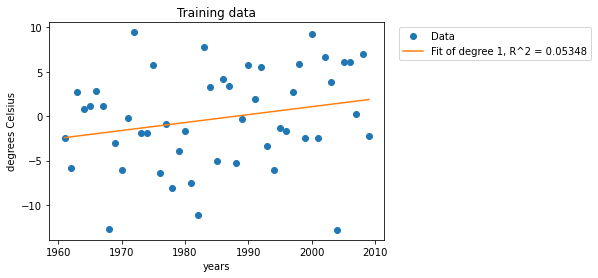

In [15]:
# randomly pick a day from a year (i.e., Jan 10t​h in this​ case)

climate = Climate("data.csv")
y = []
for year in list(TRAINING_INTERVAL):   
    y.append(climate.get_daily_temp("NEW YORK", 1, 10, year))
x = np.array(list(TRAINING_INTERVAL))
y = np.array(y)
models = generate_models(x, y, [1])
evaluate_models_on_training(x, y, models)

In [16]:
def leap_years_check(year):
    if (year % 400 == 0) and (year % 100 == 0):
        return 366
    elif (year % 4 ==0) and (year % 100 != 0):
        return 366
    else:
        return 365

D:\/ipykernel_8756/1103119293.py:8: RankWarning: Polyfit may be poorly conditioned
  models_avg_annual = generate_models(x, y, [1,2,20])


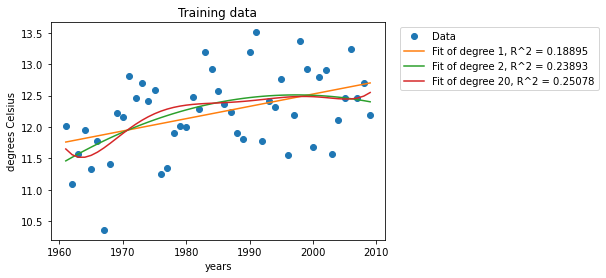

In [17]:
# average annual temperature of random City (i.e., New York in this​ case)

y = []
for year in list(TRAINING_INTERVAL):   
    y.append(climate.get_yearly_temp("NEW YORK", year).sum()/leap_years_check(year))
x = np.array(list(TRAINING_INTERVAL))
y = np.array(y)
models_avg_annual = generate_models(x, y, [1,2,20])
evaluate_models_on_training(x, y, models_avg_annual)

In [18]:
def gen_cities_avg(climate, multi_cities, years):
    avg_annual_temp = []
    num_cities = len(multi_cities)
    for year in years:
        avg_city_temp = 0
        days_in_year = leap_years_check(year)
        for city in multi_cities:
            avg_city_temp += climate.get_yearly_temp(city, year).sum()/days_in_year
        avg_annual_temp.append(avg_city_temp/num_cities)
    
    return np.array(avg_annual_temp)


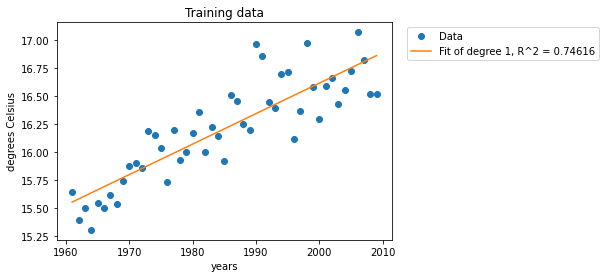

In [19]:
# national yearly temperature​ (i.e., average the yearly 
# averaged temperature over the 21 cities listed in CITIES​)

x = np.array(list(TRAINING_INTERVAL))
y = gen_cities_avg(climate, CITIES, list(TRAINING_INTERVAL))
models = generate_models(x, y, [1])
evaluate_models_on_training(x, y, models)

In [20]:
def moving_average(y, window_length):
    moving_avg = []
    for idx in range(len(y)):
        begin = idx - window_length + 1
        if begin < 0: begin = 0
        moving_avg.append(y[begin:idx+1].sum()/(idx-begin+1))
    
    return np.array(moving_avg)


D:\/ipykernel_8756/3061241374.py:7: RankWarning: Polyfit may be poorly conditioned
  models_mov_avg = generate_models(x, y, [1, 2, 20])


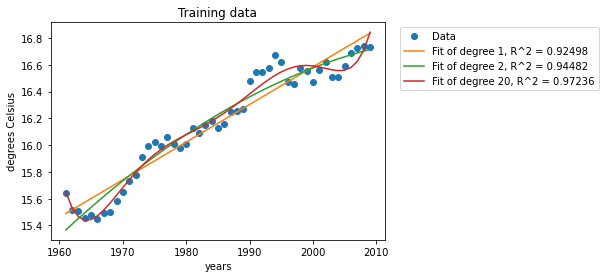

In [21]:
# moving average temperatures with a window size of 5 from 
# national yearly temperature​ 

window_length = 5
x = np.array(list(TRAINING_INTERVAL))
y = moving_average(gen_cities_avg(climate, CITIES, list(TRAINING_INTERVAL)), window_length)
models_mov_avg = generate_models(x, y, [1, 2, 20])
evaluate_models_on_training(x, y, models_mov_avg)

## Predicting the Future

In [22]:
# Root Mean Square Error (RMSE)
def RMSE(y, estimated):
    return np.sqrt(((y-estimated)**2).sum()/len(y))


In [23]:
def evaluate_models_on_testing(x, y, models):
    plt.plot(x, y, 'o', label = 'Data')
    for model in models:
        est_y = np.polyval(model, x)
        error = RMSE(y, est_y)
        plt.plot(x, est_y, label = "Fit of degree " + str(model.shape[0]-1)\
                + ", RMSE = " + str(round(error, 5)))
                
    plt.xlabel("years")
    plt.ylabel("degrees Celsius")
    plt.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left')
    plt.title("Testing data") 


### Predict the results

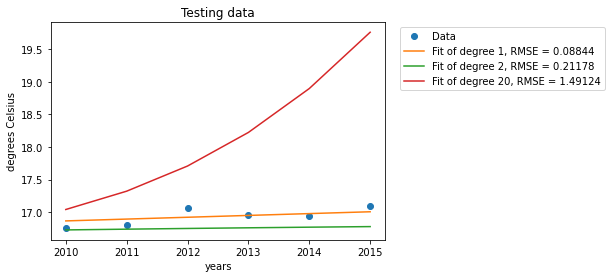

In [24]:
# moving average temperatures with a window size of 5 from 
# national yearly temperature​ 
# Test data set

window_length = 5
x = np.array(list(TESTING_INTERVAL))
y = moving_average(gen_cities_avg(climate, CITIES, list(TESTING_INTERVAL)), window_length)
evaluate_models_on_testing(x, y, models_mov_avg) #models from train data set


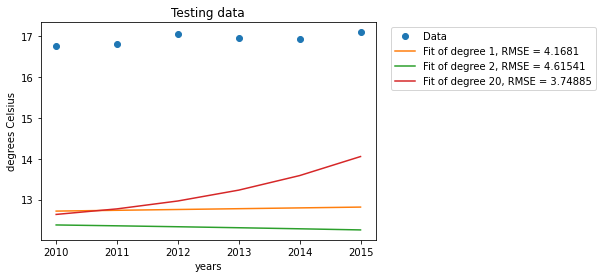

In [25]:
# average annual temperature of random City (i.e., New York in this​ case) 
# Test data set

x = np.array(list(TESTING_INTERVAL))
y = moving_average(gen_cities_avg(climate, CITIES, list(TESTING_INTERVAL)), window_length = 5)
evaluate_models_on_testing(x, y, models_avg_annual) #models from train data set


### Modeling Extreme Temperatures

In [26]:
def gen_std_devs(climate, multi_cities, years):
    cities_yearly_temp, std_devs = [], []
    nums_city = len(multi_cities)
    
    for year in years:
        for city in multi_cities:
            yearly_temp = climate.get_yearly_temp(city, year)
            cities_yearly_temp.append(yearly_temp)

        avg_cities_yearly_temp = np.sum(np.array(cities_yearly_temp), axis = 0)/nums_city
        std_devs.append(np.std(avg_cities_yearly_temp))
        cities_yearly_temp = []
    return np.array(std_devs)


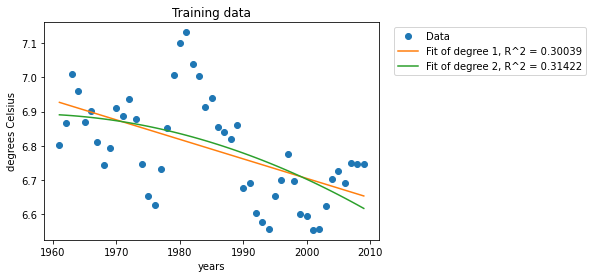

In [27]:
# temperature variation is getting narrower over these years.

std_devs = gen_std_devs(climate, CITIES, list(TRAINING_INTERVAL))
y = moving_average(std_devs, window_length = 5)
x = list(TRAINING_INTERVAL)
models_std_devs = generate_models(x, y, [1,2])
evaluate_models_on_training(x, y, models_std_devs)